# Activity 4.4 Deep Learning in Time Series

Almodiel, Mj Spencer

CPE32S8

#### Objective(s):

This activity aims to introduce how to build and train a simple RNN or LSTM for time series forecasting, using Keras.

#### Intended Learning Outcomes (ILOs):
* Demonstrate how to build and train RNN for time series forecasting
* Demonstrate how to build and train LSTM for time series forecasting


#### Resources:
* Jupyter Notebook
* Beijing.csv

#### Procedures
Load the necessary libraries

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

Build a recurrent neural network and train it to forecast a single time series. 
* Load and setup the dataset

In [2]:
df_Beijing = pd.read_csv('data\Beijing-1.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


Forecast the 'PM' series, which are measurements of air pollution for several different districts. Note that there are occasional missing values in these series, which we can fill with simple linear interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values.

In [4]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

Create a function to  extract and plot the last  𝑛  days of data 

In [5]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
       
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

Check last 6 weeks of data look like

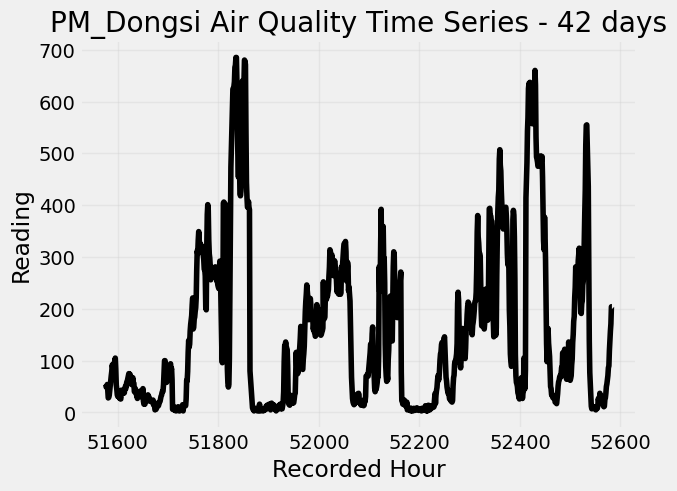

In [6]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

 Train a simple RNN to forecast the PM_Dongsi time series

In [7]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values

    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:]

    train_X, train_y = [], []

    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])

    train_X = get_keras_format_series(train_X)  
    train_y = np.array(train_y)
    
    test_X_init = test[:input_hours]
    test_y = test[input_hours:]
    
    return train_X, test_X_init, train_y, test_y

With the get_train_test_data utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model.

In [8]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each.

In [9]:
print('Training shape: {}'.format(train_X.shape))

Training shape: (436, 12, 1)


Train a simple RNN model using keras.

In [10]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Use this function to fit a very simple baseline model.

In [11]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Epoch 1/10
7/7 [==============================] - 2s 11ms/step - loss: 43072.4570
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 43049.0703
Epoch 3/10
7/7 [==============================] - 0s 10ms/step - loss: 43026.4297
Epoch 4/10
7/7 [==============================] - 0s 11ms/step - loss: 43002.6328
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 42979.6875
Epoch 6/10
7/7 [==============================] - 0s 10ms/step - loss: 42955.1523
Epoch 7/10
7/7 [==============================] - 0s 11ms/step - loss: 42930.4102
Epoch 8/10
7/7 [==============================] - 0s 11ms/step - loss: 42901.6328
Epoch 9/10
7/7 [==============================] - 0s 10ms/step - loss: 42849.0820
Epoch 10/10
7/7 [==============================] - 0s 11ms/step - loss: 42714.4688


This prediction method and a utility function for plotting its output against the ground truth are defined below. 

In [12]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) 
    
    start_range = range(1, input_hours+1)
    predict_range = range(input_hours, test_hours) 
    
    plt.plot(start_range, test_X_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

1/1 [==============================] - 0s 19ms/step


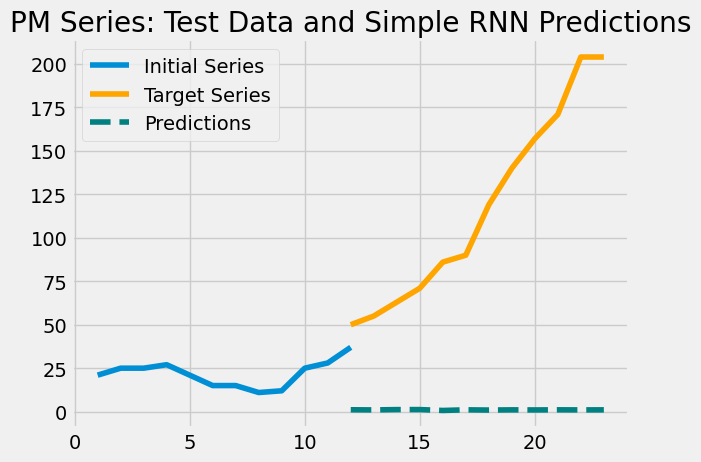

In [13]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Retrain the model a few times in order to get results that we're happy with.

Epoch 1/1200
7/7 [==============================] - 1s 20ms/step - loss: 42150.2422
Epoch 2/1200
7/7 [==============================] - 0s 15ms/step - loss: 42065.2070
Epoch 3/1200
7/7 [==============================] - 0s 12ms/step - loss: 41924.1094
Epoch 4/1200
7/7 [==============================] - 0s 12ms/step - loss: 41812.3398
Epoch 5/1200
7/7 [==============================] - 0s 12ms/step - loss: 41750.7578
Epoch 6/1200
7/7 [==============================] - 0s 14ms/step - loss: 41687.2188
Epoch 7/1200
7/7 [==============================] - 0s 12ms/step - loss: 41624.7930
Epoch 8/1200
7/7 [==============================] - 0s 11ms/step - loss: 41562.5000
Epoch 9/1200
7/7 [==============================] - 0s 11ms/step - loss: 41499.9453
Epoch 10/1200
7/7 [==============================] - 0s 11ms/step - loss: 41433.8516
Epoch 11/1200
7/7 [==============================] - 0s 12ms/step - loss: 41367.4922
Epoch 12/1200
7/7 [==============================] - 0s 12ms/step - loss: 

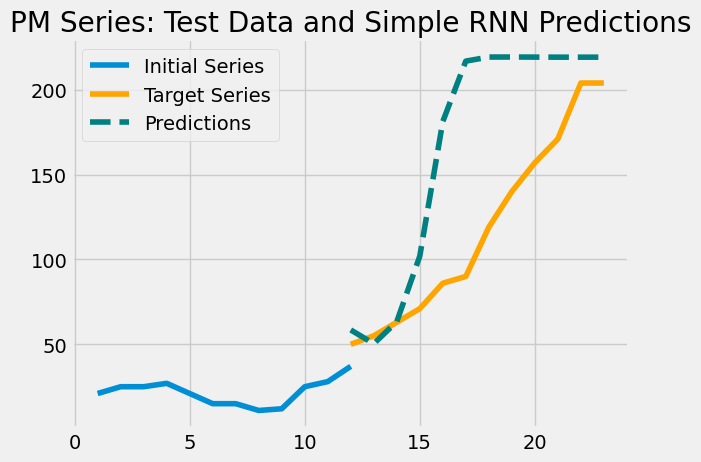

In [14]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


#### LSTM

Write a new function for fitting an LSTM with keras

In [16]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Train a LSTM to forecast the PM_Nongzhanguan time series

In [17]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

43824     8.0
43825     7.0
43826     7.0
43827    11.0
43828     5.0
43829     3.0
43830     6.0
43831     7.0
43832     9.0
43833    11.0
Name: PM_Nongzhanguan, dtype: float64

Epoch 1/3000
6/6 [==============================] - 3s 6ms/step - loss: 44398.9570
Epoch 2/3000
6/6 [==============================] - 0s 5ms/step - loss: 44339.7773
Epoch 3/3000
6/6 [==============================] - 0s 5ms/step - loss: 44273.9336
Epoch 4/3000
6/6 [==============================] - 0s 5ms/step - loss: 44167.7656
Epoch 5/3000
6/6 [==============================] - 0s 5ms/step - loss: 44028.8672
Epoch 6/3000
6/6 [==============================] - 0s 5ms/step - loss: 43931.9219
Epoch 7/3000
6/6 [==============================] - 0s 5ms/step - loss: 43810.7188
Epoch 8/3000
6/6 [==============================] - 0s 5ms/step - loss: 43603.9688
Epoch 9/3000
6/6 [==============================] - 0s 5ms/step - loss: 43292.4336
Epoch 10/3000
6/6 [==============================] - 0s 5ms/step - loss: 42991.4531
Epoch 11/3000
6/6 [==============================] - 0s 5ms/step - loss: 42656.7188
Epoch 12/3000
6/6 [==============================] - 0s 5ms/step - loss: 42280.5078
E

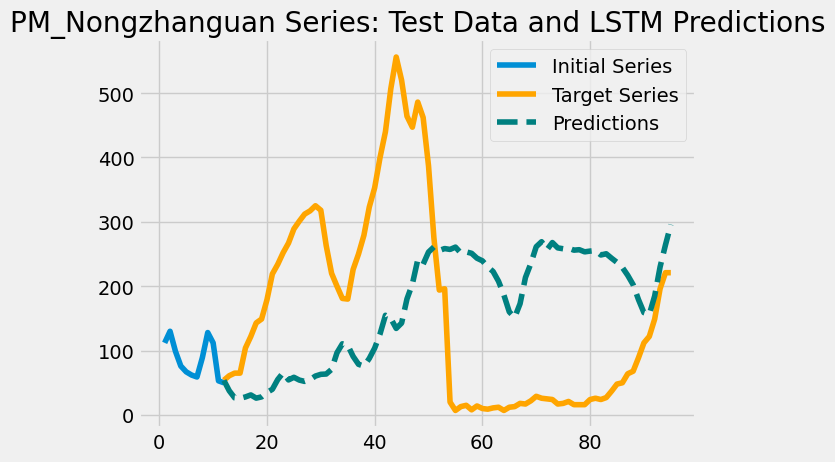

In [18]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


#### Supplementary Activity

* Train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.
* Train a LSTM to forecast the PM_Dongsi time series

- Fill missing values using interpolate

In [20]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

43824     8.0
43825     7.0
43826     7.0
43827    11.0
43828     5.0
43829     3.0
43830     6.0
43831     7.0
43832     9.0
43833    11.0
Name: PM_Nongzhanguan, dtype: float64

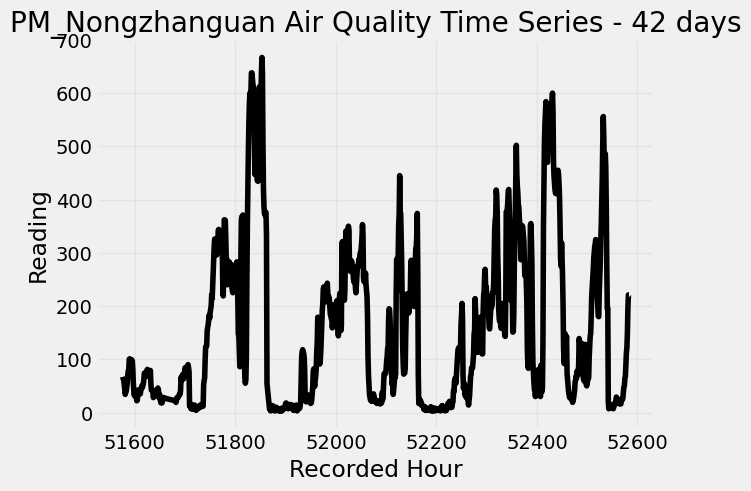

In [21]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

In [22]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

In [23]:
print('train x shape: {}'.format(train_X.shape))
print('test init x shape: {}'.format(test_X_init.shape))
print('train y shape: {}'.format(train_y.shape))
print('test y shape: {}'.format(test_y.shape))

train x shape: (436, 12, 1)
test init x shape: (12,)
train y shape: (436,)
test y shape: (12,)


In [24]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=1200)

Epoch 1/1200
7/7 [==============================] - 1s 27ms/step - loss: 41141.1602
Epoch 2/1200
7/7 [==============================] - 0s 19ms/step - loss: 41118.0039
Epoch 3/1200
7/7 [==============================] - 0s 14ms/step - loss: 41094.8906
Epoch 4/1200
7/7 [==============================] - 0s 12ms/step - loss: 41071.9688
Epoch 5/1200
7/7 [==============================] - 0s 12ms/step - loss: 41048.9180
Epoch 6/1200
7/7 [==============================] - 0s 11ms/step - loss: 41026.1836
Epoch 7/1200
7/7 [==============================] - 0s 12ms/step - loss: 41003.0781
Epoch 8/1200
7/7 [==============================] - 0s 13ms/step - loss: 40979.9648
Epoch 9/1200
7/7 [==============================] - 0s 12ms/step - loss: 40955.1641
Epoch 10/1200
7/7 [==============================] - 0s 11ms/step - loss: 40928.7344
Epoch 11/1200
7/7 [==============================] - 0s 16ms/step - loss: 40890.3633
Epoch 12/1200
7/7 [==============================] - 0s 12ms/step - loss: 

1/1 [==============================] - 0s 25ms/step


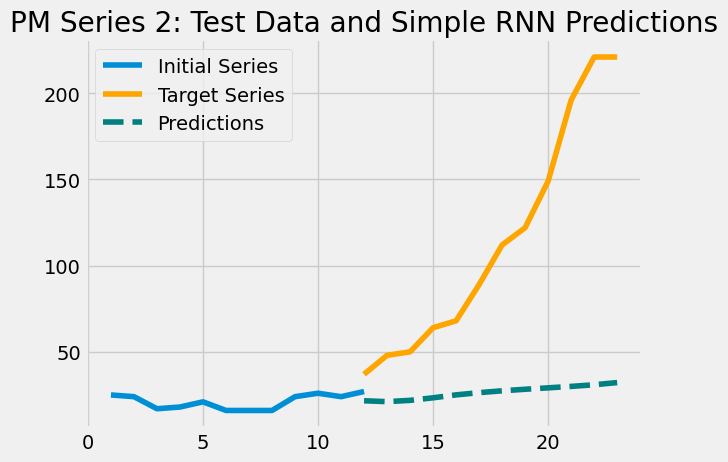

In [25]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series 2: Test Data and Simple RNN Predictions')

Epoch 1/1200
7/7 [==============================] - 1s 20ms/step - loss: 40776.6523
Epoch 2/1200
7/7 [==============================] - 0s 16ms/step - loss: 40665.9492
Epoch 3/1200
7/7 [==============================] - 0s 13ms/step - loss: 40530.5195
Epoch 4/1200
7/7 [==============================] - 0s 12ms/step - loss: 40447.4414
Epoch 5/1200
7/7 [==============================] - 0s 11ms/step - loss: 40363.4023
Epoch 6/1200
7/7 [==============================] - 0s 11ms/step - loss: 40297.8125
Epoch 7/1200
7/7 [==============================] - 0s 11ms/step - loss: 40235.4023
Epoch 8/1200
7/7 [==============================] - 0s 11ms/step - loss: 40173.0039
Epoch 9/1200
7/7 [==============================] - 0s 11ms/step - loss: 40110.7539
Epoch 10/1200
7/7 [==============================] - 0s 13ms/step - loss: 40048.4805
Epoch 11/1200
7/7 [==============================] - 0s 11ms/step - loss: 39987.1133
Epoch 12/1200
7/7 [==============================] - 0s 13ms/step - loss: 

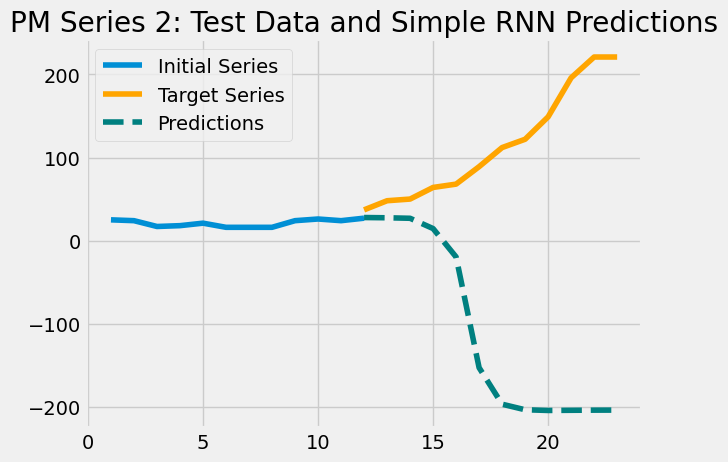

In [26]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series 2: Test Data and Simple RNN Predictions')

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3000
6/6 [==============================] - 1s 8ms/step - loss: 46499.9102
Epoch 2/3000
6/6 [==============================] - 0s 7ms/step - loss: 46399.6484
Epoch 3/3000
6/6 [==============================] - 0s 7ms/step - loss: 46286.4961
Epoch 4/3000
6/6 [==============================] - 0s 8ms/step - loss: 46157.4766
Epoch 5/3000
6/6 [==============================] - 0s 6ms/step - loss: 46043.3086
Epoch 6/3000
6/6 [==============================] - 0s 7ms/step - loss: 45960.0078
Epoch 7/3000
6/6 [==============================] - 0s 7ms/step - loss: 45845.1055
Epoch 8/3000
6/6 [==============================] - 0s 7ms/step - loss: 45727.6133
Epoch 9/3000
6/6 [==============================] - 0s 7ms/step - loss: 45560.9219
Epoch 10/3000
6/6 [==============================] - 0s 6ms/step - loss: 45308.8516
Epoch 11/3000
6/6 [==============================] - 0s 6ms/step - loss: 45072.2734
Epoch 12/3000
6/6 [==============================] - 0s 6ms/step - loss: 44812.6445
E

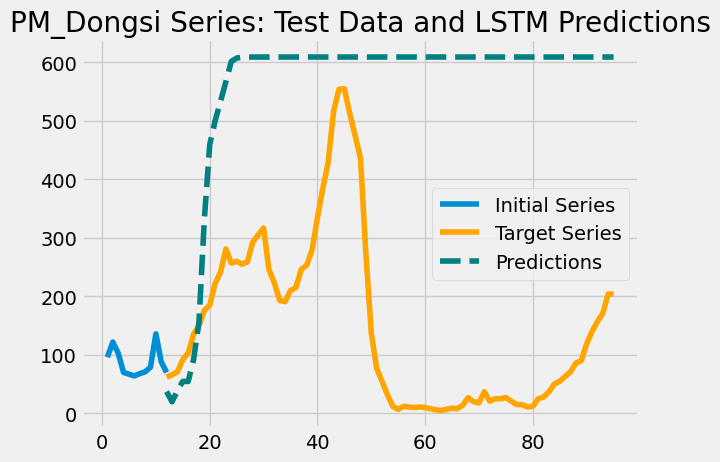

In [28]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Dongsi Series: Test Data and LSTM Predictions')

In [29]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 70)                20160     
                                                                 
 dense_5 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


#### Conclusion

- LSTM is much better version of RNN especially in forecasting values over time